In [1]:
import pandas as pd
import numpy as np

from plant_opt.models.plant_model_stages_recourse_stochastic_cvx import Plant


## Background

This notebook continues on from `compare_stochastic_nb.ipynb`, but using a model implemented in cvxpy, which allows easier implementation of some "advanced" constraints

## Sanity check

Run the model with the exact same inputs to verify creates the same results in the base case:




In [2]:
from plant_opt.scenario_tree.tree import random_walk_tree_builder

stages = 4

variables = [
            "crude_light_price",
            "crude_heavy_price",
            "prod_price_0",
            "prod_price_1",
            "prod_price_2",
            "demand_0",
            "demand_1",
            "demand_2",
        ]

root, all_nodes = random_walk_tree_builder(
        variables,
        [30, 20, 50, 40, 30, 400, 300, 200],
        [1, 1, 1, 1, 1, 30, 30, 30],
        [0, 0, 0, 0, 0, 60, 60, 60],
        stages=stages,
        branch_factor=2,
        seed=42,
        truncate_places=0,
    )

## Model Solving

In [3]:
# Some constants for all models
crude_distil_cap = 1000
products = 3
crude_ratios = [[3, 1], [1, 2], [0, 1]]
refine_caps = [1000, 1000, 1000]
product_ratios = [
            [2, 1, 0.0],  # Amount of light product from l/m/h intermediates
            [0.2, 1.0, 0.2],  # Amount of medium product from l/m/h intermediates
            [0.0, 0.8, 2.0],  # Amount of heavy product from l/m/h intermediates
        ]
allowed_output_change = 20

In [4]:
p_full = Plant(
        crude_distil_cap=crude_distil_cap,
        products=products,
        crude_ratios=crude_ratios,
        refine_caps=refine_caps,
        product_ratios=np.array(product_ratios),
        stages=stages,
        scenario_tree_root=root,
        scenario_tree_all_nodes=all_nodes,
        allowed_output_change=allowed_output_change,
    )

In [5]:
# Basic solving of the models
import cvxpy as cp
result_df = pd.DataFrame(columns=["Model", "Objective Value", "Light Crude Import", "Heavy Crude Import"])

problem = p_full.get_problem()
objective_val = problem.solve(solver=cp.CLARABEL)
result_df.loc[0] = ("Full Model", objective_val, p_full.light_crude_import[root].value, p_full.heavy_crude_import[root].value)


## Results

In [6]:
from IPython.display import display
display(result_df)

,Model,Objective Value,Light Crude Import,Heavy Crude Import
0,Full Model,102920.729059,17.333331756156987,154.77778109404323


This matches the results pyomo implementation, validating that the model is implemented in an equivalent way

## Distributions
We will cover a larger range of scenarios and then plot the distribution of outcomes by building an accessory function to calculate the objective value of a given node, and applying it, starting from the terminal nodes and tracing upwards to the root.

The values here are adjusted to reduce the outcome values, to create a chance of loss.

In [7]:
# Create a larger scenario tree and solve
stages = 6
root, all_nodes = random_walk_tree_builder(
        variables,
        [30, 20, 50, 20, 10, 400, 300, 200],
        [1, 1, 1, 1, 1, 30, 30, 30],
        [0, 0, 0, 0, 0, 60, 60, 60],
        stages=stages,
        branch_factor=5,
        seed=42,
        truncate_places=0,
    )
print(f"Generated {len(all_nodes)} nodes")

crude_ratios = [[0.7, 0.3], [0.5, 0.5], [0, 1]]  # light from [light,heavy]; medium from [light,heavy]; heavy from [light,heavy]
product_ratios = [
            [0.7, 0.3, 0.0],  # Amount of light product from l/m/h intermediates
            [0.2, 0.5, 0.2],  # Amount of medium product from l/m/h intermediates
            [0.0, 0.3, 0.7],  # Amount of heavy product from l/m/h intermediates
        ]

p_many = Plant(
        crude_distil_cap=crude_distil_cap,
        products=products,
        crude_ratios=crude_ratios,
        refine_caps=refine_caps,
        product_ratios=np.array(product_ratios),
        stages=stages,
        scenario_tree_root=root,
        scenario_tree_all_nodes=all_nodes,
        allowed_output_change=allowed_output_change,
    )
problem = p_many.get_problem()
problem.solve()

Generated 3906 nodes


/home/matthew/python/optimization/plantOpt/.venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


np.float64(13311.405397785038)

In [8]:
def calculate_node_objective(m, node):
    node_val = 0
    for output in m.outputs:
        node_val += m.prod_full_price[node][output].value * node.values[f"prod_price_{output}"]
    node_val -= m.light_crude_import[node.parent].value * node.values["crude_light_price"]
    node_val -= m.heavy_crude_import[node.parent].value * node.values["crude_heavy_price"]

    return node_val

def calculate_node_objective_recursive(m, node):
    if node.parent is None:
        # Don't calculate objective value at the root node, as the values at its children will use the import costs from it already
        return 0

    node_val = calculate_node_objective(m, node)

    return node_val + calculate_node_objective_recursive(m, node.parent)

In [9]:
terminal_nodes = [node for node in all_nodes if node.stage == stages - 1]

distributions = pd.DataFrame(columns=["Node", "Objective Value"])

for i, node in enumerate(terminal_nodes):
    distributions.loc[i] = (node.name, calculate_node_objective_recursive(p_many, node))

In [10]:
display(distributions)
print("Bot 5: ", distributions.nsmallest(5, "Objective Value"))
print("Top 5: ", distributions.nlargest(5, "Objective Value"))
print("Average: ", distributions["Objective Value"].mean())

,Node,Objective Value
0,root_0_0_0_0_0,13561.904761
1,root_0_0_0_0_1,13528.571428
2,root_0_0_0_0_2,13544.761904
3,root_0_0_0_0_3,13140.476190
4,root_0_0_0_0_4,13140.476190
...,...,...
3120,root_4_4_4_4_0,14355.396825
3121,root_4_4_4_4_1,14488.253968
3122,root_4_4_4_4_2,14488.253968
3123,root_4_4_4_4_3,14311.111110


Bot 5:                 Node  Objective Value
157  root_0_1_1_1_2      4799.206348
156  root_0_1_1_1_1      5182.063491
151  root_0_1_1_0_1      6186.349205
158  root_0_1_1_1_3      6360.634920
466  root_0_3_3_3_1      6842.906836
Top 5:                  Node  Objective Value
2653  root_4_1_1_0_3     15256.984126
2652  root_4_1_1_0_2     15252.698412
2665  root_4_1_1_3_0     15239.682539
2667  root_4_1_1_3_2     15235.396825
2656  root_4_1_1_1_1     15233.253968
Average:  13311.405397785058


%opts magic unavailable (pyparsing cannot be imported)
%compositor magic unavailable (pyparsing cannot be imported)


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
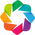

[  2   0   2   1   3   2   6   4   6  18  16  35  88 157 287 472 812 687
 433  94] [ 4799.20634844  5322.09523734  5844.98412624  6367.87301514
  6890.76190404  7413.65079294  7936.53968184  8459.42857074
  8982.31745964  9505.20634854 10028.09523744 10550.98412634
 11073.87301524 11596.76190414 12119.65079304 12642.53968194
 13165.42857084 13688.31745974 14211.20634864 14734.09523754
 15256.98412644]


:Histogram   [x]   (Frequency)

In [11]:
# Plot histogram
import numpy as np
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

frequencies, edges = np.histogram(distributions["Objective Value"], 20)
print(frequencies, edges)
hv.Histogram((edges, frequencies))

In [12]:
print(sum(distributions["Objective Value"] < 9000))
print(len(distributions))
print(10/len(distributions))

20
3125
0.0016


## Chance constraint
Now, we can attempt applying a chance constraint, which will enforce that 99.7% of the outcome values are >9000
(i.e. 10 outcomes, compared to the 20 that happened above).

In [13]:
p_chance = Plant(
        crude_distil_cap=crude_distil_cap,
        products=products,
        crude_ratios=crude_ratios,
        refine_caps=refine_caps,
        product_ratios=np.array(product_ratios),
        stages=stages,
        scenario_tree_root=root,
        scenario_tree_all_nodes=all_nodes,
        allowed_output_change=allowed_output_change,
        chance=(9000, 0.997),
    )
problem = p_chance.get_problem()
problem.solve()

distributions = pd.DataFrame(columns=["Node", "Objective Value"])

for i, node in enumerate(terminal_nodes):
    distributions.loc[i] = (node.name, calculate_node_objective_recursive(p_chance, node))

frequencies, edges = np.histogram(distributions["Objective Value"], 20)
hv.Histogram((edges, frequencies))

/home/matthew/python/optimization/plantOpt/.venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/matthew/python/optimization/plantOpt/.venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:164: UserWarning: Constraint #46850 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "
/home/matthew/python/optimization/plantOpt/.venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:164: UserWarning: Constraint #46851 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


:Histogram   [x]   (Frequency)

In [14]:
print(sum(distributions["Objective Value"] < 9000))
print(sum(distributions["Objective Value"] < 9000) / len(distributions))

12
0.00384


We see that the number of outcomes with objective < 9000 is 12, the discrepancy is investigated below:

In [22]:
print(problem.status)
print(p_chance.b.value)
print(sum(p_chance.b.value == 0))
values = np.array([x.value for x in p_chance.terminal_values.values()])
print(sum(values < 9000))

series_comp = pd.DataFrame()
series_comp["values"] = values
series_comp["mask"] = p_chance.offset_mask.value

print(series_comp[series_comp["values"] < 9000])

optimal
[1. 1. 1. ... 1. 1. 1.]
9
11
         values       mask
151  7068.57143    0.00000
156  5980.00000    0.00000
157  5635.71429    0.00000
158  7248.57143    0.00000
159  8058.57143    0.00000
180  7990.00000    0.00000
183  9000.00000 9000.00000
466  7703.92959    0.00000
1627 9000.00000 9000.00000
1628 8250.00000    0.00000
2992 7544.51770    0.00000


As can be seen, in two of the cases, the objective value is extremely close to 9000, even though it is technically below; a rounding/tolerance effect of the model. The constraint is confirmed to be working, reducing the numbers of outcomes that were <9000 from 20 to approximately 10.

In [23]:
print(distributions["Objective Value"].mean())

13259.65191756226


The new average objective value of `13260` is slightly less than the original value (prior to the chance constraint) of `13311`, which makes sense, as the model has been forced to trade maximizing the objective in favor of eliminating some of the worst case scenarios.